# Projet Neural Network - Corporación Favorita Grocery Sales Forecasting

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

## I - Imports

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random as rd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import f_regression
from seasonal import *
from statsmodels.tsa.tsatools import *
from statsmodels.tsa.stattools import *
from statsmodels.tsa.tsatools import detrend

from neural_network import neural_net_model, neural_net_model_3layers, rnn_model

In [2]:
# Refer to the py file: "processing_data.py"
from processing_data import preprocessing

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Reseaux de neurones/projet_nn/processing_data.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_small['unit_sales'] = train_small['unit_sales'].apply(lambda x:


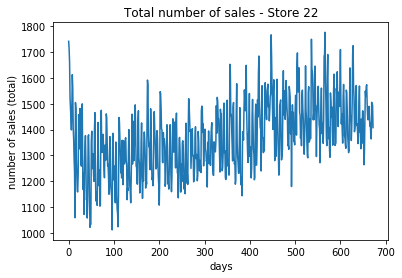

In [3]:
n = None
store_selection = 'yes'

train_all, test = preprocessing(n, store_selection)

In [4]:
print('Train - heads:')
print(train_all.head())
print()
print('---')
print('Train - shape:')
print(train_all.shape)

Train - heads:
         id        date  store_nbr  item_nbr  unit_sales onpromotion  city  \
0  58755169  2015-10-09         22    103501         7.0       False  Puyo   
1  58755170  2015-10-09         22    103520         6.0       False  Puyo   
2  58755171  2015-10-09         22    105576        47.0       False  Puyo   
3  58755172  2015-10-09         22    105693        10.0       False  Puyo   
4  58755173  2015-10-09         22    105857         7.0       False  Puyo   

     state type_x  cluster  dcoilwtico   type_y    locale locale_name  \
0  Pastaza      C        7       49.67  Holiday  National     Ecuador   
1  Pastaza      C        7       49.67  Holiday  National     Ecuador   
2  Pastaza      C        7       49.67  Holiday  National     Ecuador   
3  Pastaza      C        7       49.67  Holiday  National     Ecuador   
4  Pastaza      C        7       49.67  Holiday  National     Ecuador   

                  description transferred     family  class  perishable  \
0 

## II - Preprocessing of the data

### A - Missing data

In [5]:
# Explore and manage the missing data
print('Before missing values management:')
print('----')
missing = train_all.apply(lambda x: x.isnull().sum(), axis=0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]

# Share of missing
missing['Share of missing'] = round(missing['Number of missing values']/len(train_all)*100,2)
print(missing)

missing_rate = {}
for col in train_all.columns:
    missing_rate[col] = np.sum(train_all[col].isna())/len(train_all[col])

missing_rate_lim = 0.7

for key in missing_rate.keys():
    if missing_rate[key] > missing_rate_lim:
        train_all = train_all.drop([key], axis=1)

    if 0 < missing_rate[key] < missing_rate_lim:
        # Handle missing values - Use the mean strategy
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(np.array(train_all[key]).reshape(-1, 1))
        temp_no_miss = imp.transform(np.array(train_all[key]).reshape(-1, 1))
        train_all[key] = temp_no_miss

print()
print('After missing values management:')
print('----')
# After the management
missing = train_all.apply(lambda x: x.isnull().sum(), axis=0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]

# Share of missing
missing['Share of missing'] = round(missing['Number of missing values']/len(train_all)*100,2)
print(missing)

Before missing values management:
----
              Number of missing values  Share of missing
id                                   0              0.00
date                                 0              0.00
store_nbr                            0              0.00
item_nbr                             0              0.00
unit_sales                           0              0.00
onpromotion                          0              0.00
city                                 0              0.00
state                                0              0.00
type_x                               0              0.00
cluster                              0              0.00
dcoilwtico                      307002             33.24
type_y                          761972             82.51
locale                          761972             82.51
locale_name                     761972             82.51
description                     761972             82.51
transferred                     761972           

In [6]:
print('Train - heads:')
print(train_all.head())
print()
print('---')
print('Train - shape:')
print(train_all.shape)

Train - heads:
         id        date  store_nbr  item_nbr  unit_sales onpromotion  city  \
0  58755169  2015-10-09         22    103501         7.0       False  Puyo   
1  58755170  2015-10-09         22    103520         6.0       False  Puyo   
2  58755171  2015-10-09         22    105576        47.0       False  Puyo   
3  58755172  2015-10-09         22    105693        10.0       False  Puyo   
4  58755173  2015-10-09         22    105857         7.0       False  Puyo   

     state type_x  cluster  dcoilwtico     family  class  perishable  \
0  Pastaza      C        7       49.67   CLEANING   3008           0   
1  Pastaza      C        7       49.67  GROCERY I   1028           0   
2  Pastaza      C        7       49.67  GROCERY I   1045           0   
3  Pastaza      C        7       49.67  GROCERY I   1034           0   
4  Pastaza      C        7       49.67  GROCERY I   1092           0   

   transactions  
0        2412.0  
1        2412.0  
2        2412.0  
3        24

### B - Categorical Variables

In [7]:
# Manage category transformation
categorical_data = []
numerical_data = []

for col in train_all.columns:
    if train_all[col].dtype == 'O' and col != 'date':
        categorical_data.append(col)
    else:
        numerical_data.append(col)

# Encode the categorical data
for category_col in categorical_data:
    train_all[category_col] = train_all[category_col].astype('category').cat.codes

# Transform date to number
train_all['date'] = train_all['date'].apply(lambda x:
                                            int(''.join(i for i in x
                                                        if i.isdigit())))

### C - Fearture importance

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/louisgiron/anaconda3/lib

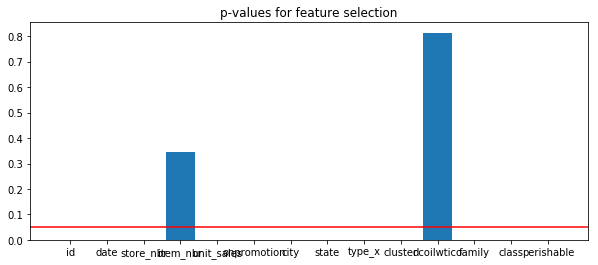

In [8]:
# Feature importance
f_value, p_values = f_regression(train_all.drop(['unit_sales'], axis=1),
                                 np.array(train_all['unit_sales']),
                                 center=True)

# Plot p-value
plt.figure(figsize=(10, 4))
plt.bar(range(len(p_values)), p_values)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title('p-values for feature selection')
plt.xticks(range(len(p_values)), train_all.columns)
plt.show()

# We select all values
# Define X and y
selection = list(train_all.columns)
try:
    selection.remove('id')
except ValueError:
    pass

### D - Statistical analysis

In [9]:
'''
# Date
train_all_processed.plot(y='unit_sales', figsize=(14, 4))

# ACF et PACF pour déterminer la saisonnalité
acf_consum = acf(train_all_processed['unit_sales'])
pacf_consum = pacf(train_all_processed['unit_sales'])
fig = plt.figure(figsize=(7, 5))
plt.bar(np.arange(0, len(acf_consum)), acf_consum)
plt.title('ACF')
plt.show()
fig = plt.figure(figsize=(7, 5))
plt.bar(np.arange(0, len(pacf_consum)), pacf_consum)
plt.title('PACF')
plt.show()

notrend = detrend(train_all_processed.unit_sales)
train_all_processed["notrend"] = notrend
train_all_processed.plot(y=["unit_sales", "notrend"], figsize=(14,4))

cv_seasons, trend = fit_seasons(train_all_processed["notrend"])
train_all_processed['unit_sales'] = trend

train_all_processed.plot(y=["unit_sales", "notrend"], figsize=(14,4))
'''

'\n# Date\ntrain_all_processed.plot(y=\'unit_sales\', figsize=(14, 4))\n\n# ACF et PACF pour déterminer la saisonnalité\nacf_consum = acf(train_all_processed[\'unit_sales\'])\npacf_consum = pacf(train_all_processed[\'unit_sales\'])\nfig = plt.figure(figsize=(7, 5))\nplt.bar(np.arange(0, len(acf_consum)), acf_consum)\nplt.title(\'ACF\')\nplt.show()\nfig = plt.figure(figsize=(7, 5))\nplt.bar(np.arange(0, len(pacf_consum)), pacf_consum)\nplt.title(\'PACF\')\nplt.show()\n\nnotrend = detrend(train_all_processed.unit_sales)\ntrain_all_processed["notrend"] = notrend\ntrain_all_processed.plot(y=["unit_sales", "notrend"], figsize=(14,4))\n\ncv_seasons, trend = fit_seasons(train_all_processed["notrend"])\ntrain_all_processed[\'unit_sales\'] = trend\n\ntrain_all_processed.plot(y=["unit_sales", "notrend"], figsize=(14,4))\n'

### E - Final train set

In [10]:
train_all_processed = train_all[selection]

print('X train original shape:', train_all.shape)
print('X train processed shape:', train_all_processed.shape)

X train original shape: (923483, 15)
X train processed shape: (923483, 14)


## III - Training setup

In [11]:
# Train size
train_size_ratio = 0.6
valid_train_size_ratio = 0.1

size = train_all_processed.shape[0]

train_set = np.arange(0, int(train_size_ratio*size))
valid_set = np.arange(int(train_size_ratio*size), int(train_size_ratio*size)
                      + int(valid_train_size_ratio*size))
test_set = np.arange(int(train_size_ratio*size+valid_train_size_ratio*size),
                     int(size))

# Split the train data to learn # Warning date -> split linearly
X_train = train_all_processed.drop(['unit_sales'], axis=1).loc[train_set]
y_train = train_all_processed['unit_sales'].loc[train_set]
X_valid = train_all_processed.drop(['unit_sales'], axis=1).loc[valid_set]
y_valid = train_all_processed['unit_sales'].loc[valid_set]
X_test = train_all_processed.drop(['unit_sales'], axis=1).loc[test_set]
y_test = train_all_processed['unit_sales'].loc[test_set]

# Norlmalize data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train.values)
y_train_norm = scaler.fit_transform(y_train.values.reshape(-1, 1))

X_valid_norm = scaler.fit_transform(X_valid.values)
y_valid_norm = scaler.fit_transform(y_valid.values.reshape(-1, 1))

X_test_norm = scaler.fit_transform(X_test.values)
y_test_norm = scaler.fit_transform(y_test.values.reshape(-1, 1))

print('X train shape:', X_train.shape)
print('X valid shape:', X_valid.shape)
print('X test shape:', X_test.shape)

def denormalize(y_train, norm_data):
    try:
        df = y_train.values.reshape(-1, 1)
    except AttributeError:
        df = y_train.reshape(-1, 1)
    norm_data = norm_data.reshape(-1, 1)
    scl = MinMaxScaler()
    scl.fit_transform(df)
    return scl.inverse_transform(norm_data)

X train shape: (554089, 13)
X valid shape: (92348, 13)
X test shape: (277045, 13)


## IV - 2 layers neural network

### A - Model initialization

In [12]:
# Input data
nb_epoch = 20
nb_input = X_train.shape[1]
nb_hidden1 = 10
nb_hidden2 = 6
batch_size = 1000

# Initialize the model
X_tf = tf.placeholder(tf.float32)
y_tf = tf.placeholder(tf.float32)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)

output = neural_net_model(X_tf, nb_input, nb_hidden1, nb_hidden2, keep_prob_1, keep_prob_2)
avg_cost_v = []
c_t = []
c_valid = []
l_rate_v = []

# Drop out level
prob_1 = 0.8
prob_2 = 0.8

cost = tf.reduce_mean(tf.square(output-y_tf))
'''
# Piecewise constant
min_lr = 0.1
max_lr = 0.5
nb_values = nb_epoch

global_step = tf.Variable(0, trainable=False)
boundaries = list(np.linspace(batch_size,
                              batch_size*nb_epoch, nb_values,
                              dtype=np.int32)[:-1])
values = list(np.round(np.linspace(max_lr, min_lr, nb_values), 2))
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

j = 0
# Passing global_step to minimize() will increment it at each step.
learning_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost,
                                                                 global_step=global_step)'''

# Exponential decay of the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           int(X_train.shape[0]/batch_size),
                                           0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
learning_step = (
    tf.train.AdamOptimizer(learning_rate).minimize(cost,
                                                   global_step=global_step))
j = 0

### B - Model training

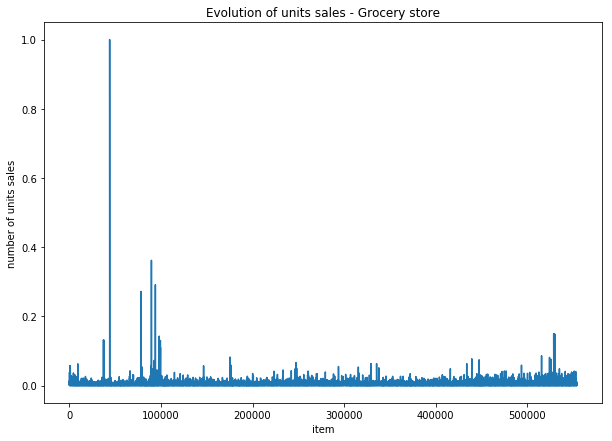

In [13]:
# Initial plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.title('Evolution of units sales - Grocery store')
ax.plot(range(len(y_train)), y_train_norm, label='Original')
plt.show()

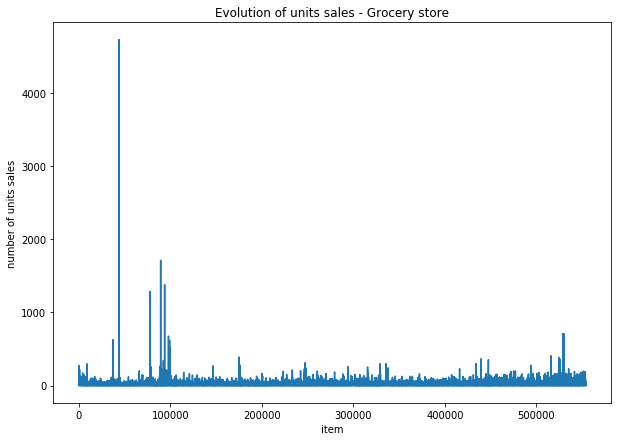

  5%|▌         | 1/20 [00:00<00:11,  1.59it/s]

Epoch : 1 Cost train: 7.3548505336570715e-09 Cost valid: 3.368354e-05 Learning rate: [0.1]


 10%|█         | 2/20 [00:01<00:11,  1.62it/s]

Epoch : 2 Cost train: 7.147595734694394e-09 Cost valid: 3.296343e-05 Learning rate: [0.096]


 15%|█▌        | 3/20 [00:01<00:10,  1.62it/s]

Epoch : 3 Cost train: 7.1515522008158256e-09 Cost valid: 3.331394e-05 Learning rate: [0.09216]


 20%|██        | 4/20 [00:02<00:09,  1.64it/s]

Epoch : 4 Cost train: 7.277760186715098e-09 Cost valid: 3.3783883e-05 Learning rate: [0.088473596]


 25%|██▌       | 5/20 [00:03<00:09,  1.62it/s]

Epoch : 5 Cost train: 7.1903805653266235e-09 Cost valid: 3.3192304e-05 Learning rate: [0.084934644]


 30%|███       | 6/20 [00:03<00:08,  1.61it/s]

Epoch : 6 Cost train: 7.1476671480870426e-09 Cost valid: 3.2864347e-05 Learning rate: [0.08153726]


 35%|███▌      | 7/20 [00:04<00:08,  1.59it/s]

Epoch : 7 Cost train: 7.170727928007267e-09 Cost valid: 3.314354e-05 Learning rate: [0.07827577]


 40%|████      | 8/20 [00:04<00:07,  1.61it/s]

Epoch : 8 Cost train: 7.153282539111256e-09 Cost valid: 3.247839e-05 Learning rate: [0.07514474]


 45%|████▌     | 9/20 [00:05<00:06,  1.60it/s]

Epoch : 9 Cost train: 7.673067790454015e-09 Cost valid: 3.1945365e-05 Learning rate: [0.07213895]


 50%|█████     | 10/20 [00:06<00:06,  1.61it/s]

Epoch : 10 Cost train: 7.147681923271728e-09 Cost valid: 3.523724e-05 Learning rate: [0.069253385]


 55%|█████▌    | 11/20 [00:06<00:05,  1.62it/s]

Epoch : 11 Cost train: 7.149376965292632e-09 Cost valid: 3.2689226e-05 Learning rate: [0.06648325]


 60%|██████    | 12/20 [00:07<00:04,  1.64it/s]

Epoch : 12 Cost train: 7.91812982449698e-09 Cost valid: 3.4812274e-05 Learning rate: [0.063823916]


 65%|██████▌   | 13/20 [00:07<00:04,  1.65it/s]

Epoch : 13 Cost train: 8.890591438339405e-09 Cost valid: 3.2339492e-05 Learning rate: [0.06127096]


 70%|███████   | 14/20 [00:08<00:03,  1.67it/s]

Epoch : 14 Cost train: 8.201902021573257e-09 Cost valid: 3.2837957e-05 Learning rate: [0.058820125]


 75%|███████▌  | 15/20 [00:09<00:02,  1.67it/s]

Epoch : 15 Cost train: 7.606682064816934e-09 Cost valid: 3.2632423e-05 Learning rate: [0.056467313]


 80%|████████  | 16/20 [00:09<00:02,  1.67it/s]

Epoch : 16 Cost train: 7.434648843614522e-09 Cost valid: 3.4600507e-05 Learning rate: [0.054208618]


 85%|████████▌ | 17/20 [00:10<00:01,  1.67it/s]

Epoch : 17 Cost train: 1.2786576162102475e-08 Cost valid: 3.1768188e-05 Learning rate: [0.052040275]


 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

Epoch : 18 Cost train: 7.176846496154393e-09 Cost valid: 3.239355e-05 Learning rate: [0.04995866]


 95%|█████████▌| 19/20 [00:11<00:00,  1.66it/s]

Epoch : 19 Cost train: 7.179052102890551e-09 Cost valid: 3.2204767e-05 Learning rate: [0.047960315]


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

Epoch : 20 Cost train: 7.166993089656124e-09 Cost valid: 3.2053085e-05 Learning rate: [0.046041902]
Cost - Test phase: 7.254717e-05


In [14]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(y_train, y_train_norm)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlabel('item')
    plt.ylabel('number of units sales')
    plt.title('Evolution of units sales - Grocery store')
    ax.plot(range(len(y_train)), y_t, label='Original')
    plt.show()

    '''try:
        saver.restore(sess, 'NN_favorita_grocery_sales.ckpt')
    except Exception:
        pass'''

    for epoch in tqdm(range(nb_epoch)):

        # Create the batches
        total_batch = int(X_train.shape[0]/batch_size)

        # Run training on batch
        for i in range(total_batch):
            avg_cost = 0.
            # Increment the learning rate with exponential decay
            l_rate = sess.run([learning_rate], {global_step: j})
            l_rate_v.append(l_rate)
            j += 1

            batch_X = X_train_norm[i*batch_size:(i+1)*batch_size]
            batch_y = y_train_norm[i*batch_size:(i+1)*batch_size]

            # Run the train
            _, c = sess.run([learning_step, cost],
                            feed_dict={X_tf: batch_X, y_tf: batch_y,
                                       keep_prob_1: prob_1,
                                       keep_prob_2: prob_2})
            # Compute average cost on train set
            c_t.append(c)
            avg_cost += c / total_batch
        avg_cost_v.append(avg_cost)
        
        # Compute the cost on valid set
        pred_norm, cost_valid = sess.run([output, cost],
                                         feed_dict={X_tf: X_valid_norm,
                                                    y_tf: y_valid_norm,
                                                    keep_prob_1: 1.0,
                                                    keep_prob_2: 1.0})
        c_valid.append(cost_valid)
        pred = denormalize(y_train, pred_norm)

        print('Epoch :', epoch+1, 'Cost train:', avg_cost_v[epoch], 'Cost valid:', c_valid[epoch],
              'Learning rate:', l_rate)

    # Compute the cost on test set
    print('Cost - Test phase:', sess.run(cost, feed_dict={X_tf: X_test_norm,
                                                          y_tf: y_test_norm,
                                                          keep_prob_1: 1.0,
                                                          keep_prob_2: 1.0}))
    pred_test_norm = sess.run(output, feed_dict={X_tf: X_test_norm,
                                                keep_prob_1: 1.0,
                                                keep_prob_2: 1.0})
    pred_test = denormalize(y_train, pred_test_norm)

    '''
    # Save the model
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/NN_favorita_grocery_sales.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

### C - Visualisation

#### Cost of the prediction

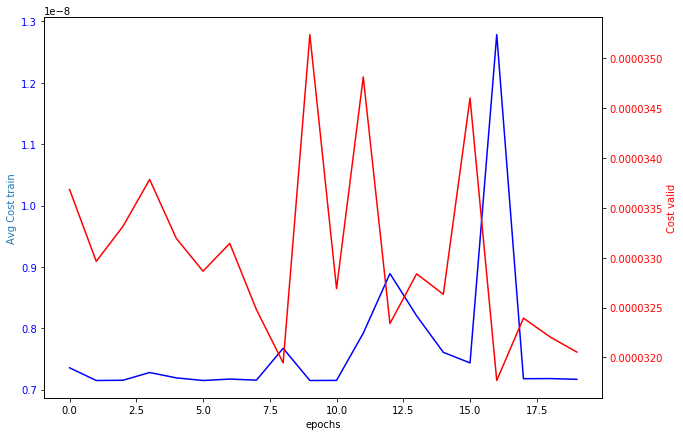

In [15]:
# Plot the costs
fig, ax1 = plt.subplots(figsize=(10, 7))
x = np.arange(nb_epoch)
ax1.plot(x, avg_cost_v, 'b-')
ax1.set_xlabel('epochs')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Avg Cost train', color='C0')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(x, c_valid, 'r-')
ax2.set_ylabel('Cost valid', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')  
plt.show()

#### Learning rate through epochs

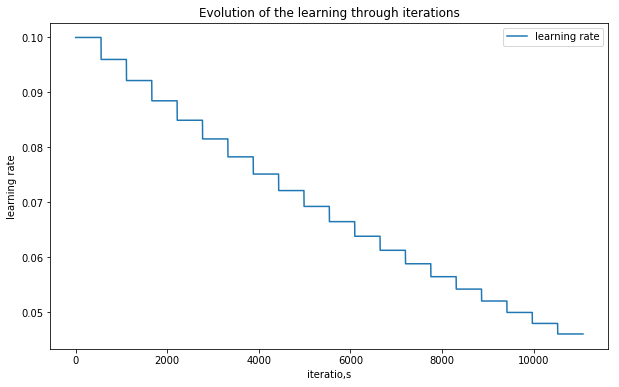

In [16]:
# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(l_rate_v, label="learning rate")
plt.legend(loc='best')
plt.ylabel('learning rate')
plt.xlabel('iteratio,s')
plt.title('Evolution of the learning through iterations')
plt.show()

#### Normalized predictions against normalized original values
Use to check whether the denormalization process is consistent

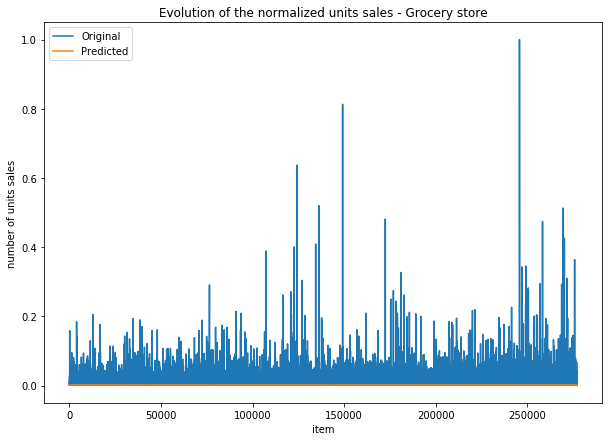

In [17]:
# Plot normalized predictions vs normalized original
fig = plt.figure(figsize=(10, 7))
plt.plot(y_test_norm, label='Original')
plt.plot(pred_test_norm, label='Predicted')
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.legend(loc='best')
plt.title('Evolution of the normalized units sales - Grocery store')
plt.show()

#### Predictions against original values

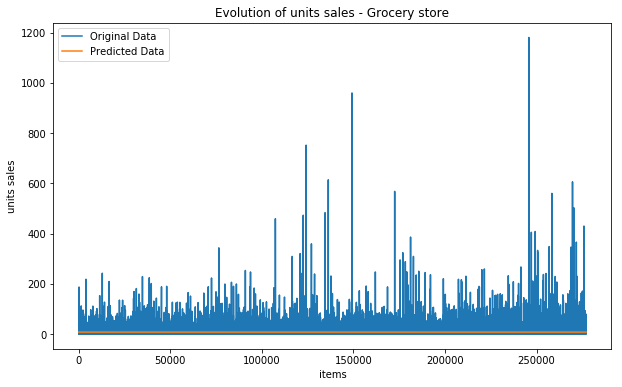

In [18]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

#### Predictions only
Use to observe more precisely the predictions

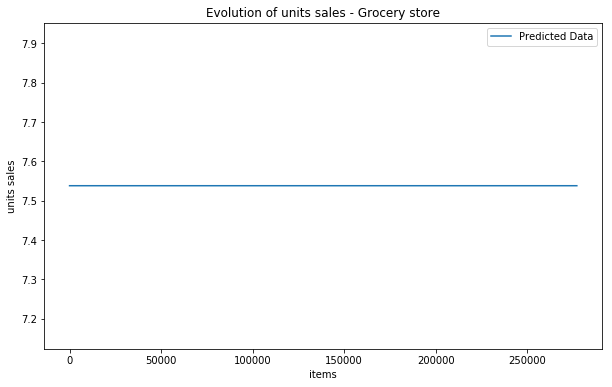

In [19]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

## V - 3 layers neural network

### A - Model initialization

In [20]:
# Input data
nb_epoch = 20
nb_input = X_train.shape[1]
nb_hidden1 = 12
nb_hidden2 = 8
nb_hidden3 = 4
batch_size = 1000

# Initialize the model
X_tf = tf.placeholder(tf.float32)
y_tf = tf.placeholder(tf.float32)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)
keep_prob_3 = tf.placeholder(tf.float32)

output = neural_net_model_3layers(X_tf, nb_input, nb_hidden1, nb_hidden2, nb_hidden3,
                                  keep_prob_1, keep_prob_2, keep_prob_3)
avg_cost_v = []
c_t = []
c_valid = []
l_rate_v = []

# Drop out level
prob_1 = 0.7
prob_2 = 0.8
prob_3 = 0.9

cost = tf.reduce_mean(tf.square(output-y_tf))
'''
# Piecewise constant
min_lr = 0.1
max_lr = 0.5
nb_values = nb_epoch

global_step = tf.Variable(0, trainable=False)
boundaries = list(np.linspace(batch_size,
                              batch_size*nb_epoch, nb_values,
                              dtype=np.int32)[:-1])
values = list(np.round(np.linspace(max_lr, min_lr, nb_values), 2))
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

j = 0
# Passing global_step to minimize() will increment it at each step.
learning_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost,
                                                                 global_step=global_step)'''

# Exponential decay of the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           int(X_train.shape[0]/batch_size),
                                           0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
learning_step = (
    tf.train.AdamOptimizer(learning_rate).minimize(cost,
                                                   global_step=global_step))
j = 0

### B - Model training

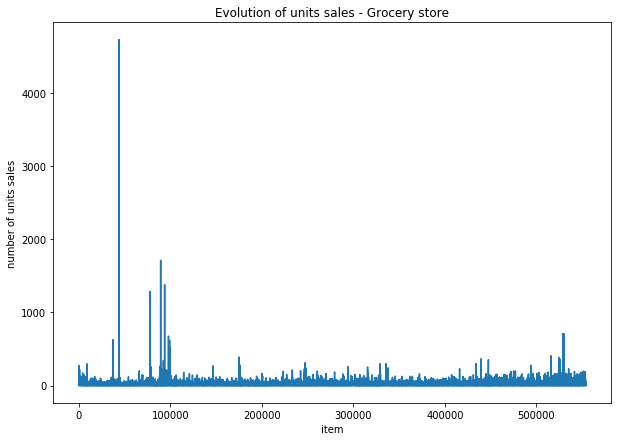

  5%|▌         | 1/20 [00:00<00:16,  1.18it/s]

Epoch : 1 Cost train: 9.415440473811439e-09 Cost valid: 8.701788e-05 Learning rate: [0.1]


 10%|█         | 2/20 [00:01<00:14,  1.23it/s]

Epoch : 2 Cost train: 7.248413386554642e-09 Cost valid: 7.718488e-05 Learning rate: [0.096]


 15%|█▌        | 3/20 [00:02<00:13,  1.27it/s]

Epoch : 3 Cost train: 7.1908952342598475e-09 Cost valid: 7.627937e-05 Learning rate: [0.09216]


 20%|██        | 4/20 [00:03<00:12,  1.28it/s]

Epoch : 4 Cost train: 7.147493950088781e-09 Cost valid: 9.940887e-05 Learning rate: [0.088473596]


 25%|██▌       | 5/20 [00:03<00:11,  1.29it/s]

Epoch : 5 Cost train: 7.175958343386055e-09 Cost valid: 9.9432116e-05 Learning rate: [0.084934644]


 30%|███       | 6/20 [00:04<00:10,  1.30it/s]

Epoch : 6 Cost train: 7.1826301601153064e-09 Cost valid: 9.937915e-05 Learning rate: [0.08153726]


 35%|███▌      | 7/20 [00:05<00:09,  1.30it/s]

Epoch : 7 Cost train: 7.935388881897231e-09 Cost valid: 9.938968e-05 Learning rate: [0.07827577]


 40%|████      | 8/20 [00:06<00:09,  1.28it/s]

Epoch : 8 Cost train: 7.552608172241128e-09 Cost valid: 0.00010022447 Learning rate: [0.07514474]


 45%|████▌     | 9/20 [00:06<00:08,  1.30it/s]

Epoch : 9 Cost train: 7.189262576352062e-09 Cost valid: 9.942274e-05 Learning rate: [0.07213895]


 50%|█████     | 10/20 [00:07<00:07,  1.32it/s]

Epoch : 10 Cost train: 8.3394778704011e-09 Cost valid: 9.938745e-05 Learning rate: [0.069253385]


 55%|█████▌    | 11/20 [00:08<00:06,  1.34it/s]

Epoch : 11 Cost train: 7.322579888616006e-09 Cost valid: 0.00010005867 Learning rate: [0.06648325]


 60%|██████    | 12/20 [00:09<00:05,  1.35it/s]

Epoch : 12 Cost train: 7.256950980772278e-09 Cost valid: 0.000100625446 Learning rate: [0.063823916]


 65%|██████▌   | 13/20 [00:09<00:05,  1.37it/s]

Epoch : 13 Cost train: 7.903093611548356e-09 Cost valid: 0.000100140045 Learning rate: [0.06127096]


 70%|███████   | 14/20 [00:10<00:04,  1.39it/s]

Epoch : 14 Cost train: 7.148680069081616e-09 Cost valid: 9.942565e-05 Learning rate: [0.058820125]


 75%|███████▌  | 15/20 [00:11<00:03,  1.40it/s]

Epoch : 15 Cost train: 7.598797041256256e-09 Cost valid: 9.938206e-05 Learning rate: [0.056467313]


 80%|████████  | 16/20 [00:11<00:02,  1.38it/s]

Epoch : 16 Cost train: 7.3372918683451365e-09 Cost valid: 9.9410936e-05 Learning rate: [0.054208618]


 85%|████████▌ | 17/20 [00:12<00:02,  1.39it/s]

Epoch : 17 Cost train: 7.317216496575045e-09 Cost valid: 9.941182e-05 Learning rate: [0.052040275]


 90%|█████████ | 18/20 [00:13<00:01,  1.40it/s]

Epoch : 18 Cost train: 7.252474099812467e-09 Cost valid: 9.938919e-05 Learning rate: [0.04995866]


 95%|█████████▌| 19/20 [00:14<00:00,  1.41it/s]

Epoch : 19 Cost train: 7.178977406123528e-09 Cost valid: 9.9390534e-05 Learning rate: [0.047960315]


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

Epoch : 20 Cost train: 7.166994731343311e-09 Cost valid: 9.941242e-05 Learning rate: [0.046041902]
Cost - Test phase: 7.2882445e-05


In [21]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(y_train, y_train_norm)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlabel('item')
    plt.ylabel('number of units sales')
    plt.title('Evolution of units sales - Grocery store')
    ax.plot(range(len(y_train)), y_t, label='Original')
    plt.show()

    '''try:
        saver.restore(sess, 'NN_favorita_grocery_sales.ckpt')
    except Exception:
        pass'''

    for epoch in tqdm(range(nb_epoch)):

        # Create the batches
        total_batch = int(X_train.shape[0]/batch_size)

        # Run training on batch
        for i in range(total_batch):
            avg_cost = 0.
            # Increment the learning rate with exponential decay
            l_rate = sess.run([learning_rate], {global_step: j})
            l_rate_v.append(l_rate)
            j += 1

            batch_X = X_train_norm[i*batch_size:(i+1)*batch_size]
            batch_y = y_train_norm[i*batch_size:(i+1)*batch_size]

            # Run the train
            _, c = sess.run([learning_step, cost],
                            feed_dict={X_tf: batch_X, y_tf: batch_y,
                                       keep_prob_1: prob_1,
                                       keep_prob_2: prob_2,
                                       keep_prob_3: prob_3})
            # Compute average cost on the train set
            c_t.append(c)
            avg_cost += c / total_batch
        avg_cost_v.append(avg_cost)
        
        # Compute the cost on the valid set
        pred_norm, cost_valid = sess.run([output, cost],
                                         feed_dict={X_tf: X_valid_norm,
                                                    y_tf: y_valid_norm,
                                                    keep_prob_1: 1.0,
                                                    keep_prob_2: 1.0,
                                                    keep_prob_3: 1.0})
        c_valid.append(cost_valid)
        pred = denormalize(y_train, pred_norm)

        print('Epoch :', epoch+1, 'Cost train:', avg_cost_v[epoch], 'Cost valid:', c_valid[epoch],
              'Learning rate:', l_rate)

    # Compute the cost on the test set
    print('Cost - Test phase:', sess.run(cost, feed_dict={X_tf: X_test_norm,
                                                          y_tf: y_test_norm,
                                                          keep_prob_1: 1.0,
                                                          keep_prob_2: 1.0,
                                                          keep_prob_3: 1.0}))
    pred_test_norm = sess.run(output, feed_dict={X_tf: X_test_norm,
                                                keep_prob_1: 1.0,
                                                keep_prob_2: 1.0,
                                                keep_prob_3: 1.0})
    pred_test = denormalize(y_train, pred_test_norm)

    '''
    # Save the model
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/NN_favorita_grocery_sales.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

### C - Visualisation

#### Cost of the prediction

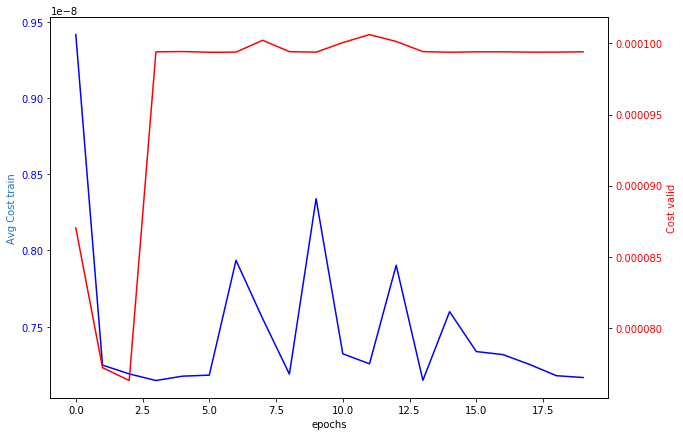

In [22]:
# Plot the costs
fig, ax1 = plt.subplots(figsize=(10, 7))
x = np.arange(nb_epoch)
ax1.plot(x, avg_cost_v, 'b-')
ax1.set_xlabel('epochs')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Avg Cost train', color='C0')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(x, c_valid, 'r-')
ax2.set_ylabel('Cost valid', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')  
plt.show()

#### Learning rate through epochs

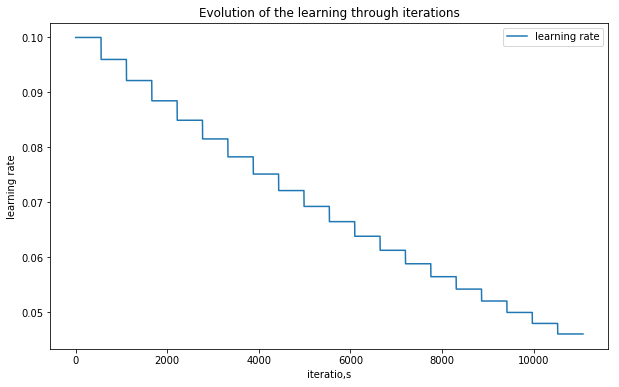

In [23]:
# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(l_rate_v, label="learning rate")
plt.legend(loc='best')
plt.ylabel('learning rate')
plt.xlabel('iteratio,s')
plt.title('Evolution of the learning through iterations')
plt.show()

#### Normalized predictions against normalized original values
Use to check whether the denormalization process is consistent

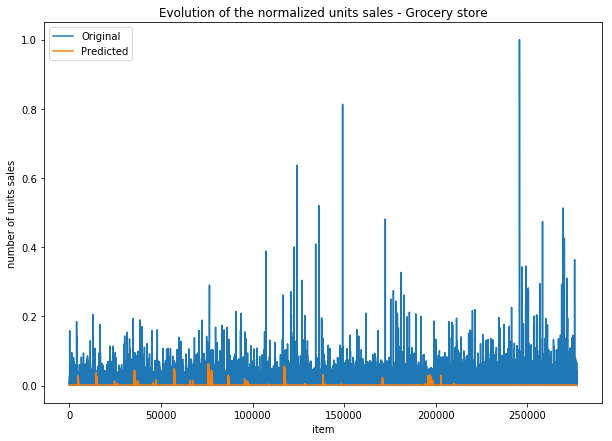

In [24]:
# Plot normalized predictions vs normalized original
fig = plt.figure(figsize=(10, 7))
plt.plot(y_test_norm, label='Original')
plt.plot(pred_test_norm, label='Predicted')
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.legend(loc='best')
plt.title('Evolution of the normalized units sales - Grocery store')
plt.show()

#### Predictions against original values

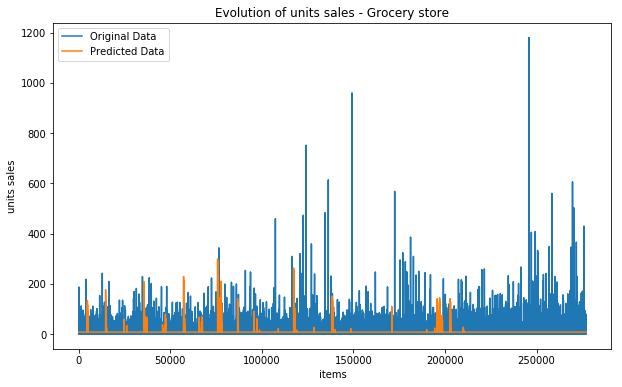

In [25]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

#### Predictions only
Use to observe more precisely the predictions

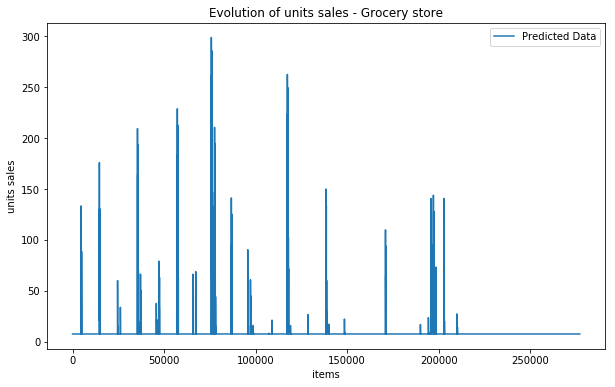

In [26]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

## VI - Reccurent neural network

### A - Model initialization

#### Input data

In [27]:
nb_inputs = X_train.shape[0]
num_components = X_train.shape[1]

nb_epoch = 50
num_hidden = 32
learning_rate = 0.001
lambda_loss = 0.001
batch_size = 1000

acc_t = []
loss_t = []
acc_val = []
loss_val = []

#### Graph definition

In [28]:
graph = tf.Graph()
with graph.as_default():
    # 1) First we put the input data in a tensorflow friendly form.
    X_tf = tf.placeholder(tf.float32, shape=(None, nb_inputs,
                                             num_components))
    y_tf = tf.placeholder(tf.float32)

    # 2) Then we choose the model to calculate the logits (predicted labels)
    # We can choose from several models:
    logits = rnn_model(X_tf, num_hidden)
    # logits = lstm_rnn_model(tf_dataset, num_hidden, num_labels)

    # 3) Then we compute the softmax cross entropy between the logits and
    # the (actual) labels
    l2 = lambda_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)) + l2

    # 4)
    # The optimizer is used to calculate the gradients of the loss function
    # optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    prediction = tf.nn.softmax(logits)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


KeyboardInterrupt: 

### B - Model training

In [ ]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print("\nInitialized")

    for epoch in tqdm(range(nb_epoch)):

        # Create the batches
        total_batch = int(X_train.shape[0]/batch_size)

        # Run training on batch
        for i in range(total_batch):
            # Since we are using stochastic gradient descent, we are selecting
            # small batches from the training dataset, and training the
            # convolutional neural network each time with a batch.
            batch_X = X_train_norm[i*batch_size:(i+1)*batch_size]
            batch_y = y_train_norm[i*batch_size:(i+1)*batch_size]

            feed_dict = {X_tf: batch_X, y_tf: batch_y}
            _, l, train_predictions = sess.run([optimizer, loss, prediction],
                                               feed_dict=feed_dict)
            train_accuracy = accuracy(train_predictions, batch_y)
        acc_t.append(train_accuracy)
        loss_t.append(l)

        feed_dict = {X_tf: X_valid_norm, y_tf: y_valid_norm}
        l_val, valid_predictions = sess.run([loss, prediction],
                                            feed_dict=feed_dict)
        valid_accuracy = accuracy(valid_predictions, y_valid_norm)
        print('Epoch ', str(epoch), ': ', ' - Accuracy on train set:',
                train_accuracy, ' - Accuract on valid set:',  valid_accuracy)

        acc_val.append(valid_accuracy)
        loss_val.append(l_val)

    # Test set
    feed_dict = {X_tf: X_test_norm, y_tf: y_test_norm}
    _, test_predictions = sess.run([loss, prediction], feed_dict=feed_dict)
    valid_accuracy = accuracy(test_predictions, y_test_norm)
    print('Accuracy on test set:', valid_accuracy)

    # Close the session
    sess.close()

#### Denormalize predictions

In [ ]:
pred_test = denormalize(y_test, test_predictions)

### C - Visualization

#### Cost of the prediction

In [ ]:
# Plot the costs
fig, ax1 = plt.subplots(figsize=(10, 7))
x = np.arange(nb_epoch)
ax1.plot(x, loss_t, 'b-')
ax1.set_xlabel('epochs')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Avg Cost train', color='C0')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(x, loss_val, 'r-')
ax2.set_ylabel('Cost valid', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')  
plt.show()

#### Predictions against original values

In [ ]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()